Número total de observaciones: 795
Features usadas: ['GS10', 'CPIAUCSL', 'Unemployment rate', 'POP', 'NA000334Q', 'PCE']

Tamaño train: 636
Tamaño test : 159

==== LinearRegression (sin regularización) ====
MSE   train: 1.6587   test: 1.2476
MAE   train: 0.9474   test: 0.8675
R^2   train: 0.8753   test: 0.8927

CV MSE LinearRegression (media ± std): 1.7354250579733688 ± 0.3692765043569615

Mejor alpha Ridge: 0.1
Mejor CV MSE Ridge: 1.7316580713354086

==== Ridge (L2) ====
MSE   train: 1.6600   test: 1.2367
MAE   train: 0.9440   test: 0.8645
R^2   train: 0.8752   test: 0.8937

Mejor alpha Lasso: 0.01
Mejor CV MSE Lasso: 1.7731295999697836

==== Lasso (L1) ====
MSE   train: 1.7216   test: 1.1926
MAE   train: 0.9345   test: 0.8318
R^2   train: 0.8706   test: 0.8975

Coeficientes Lasso por variable:
GS10                : 3.6857
CPIAUCSL            : -1.9879
Unemployment rate   : -0.7280
POP                 : 0.0237
NA000334Q           : 2.0658
PCE                 : 0.0000

Variables selecc

/opt/anaconda3/envs/ML2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



skforecast version: 0.18.0
Frecuencia inferida del índice (Sarimax): MS

Tamaño serie Sarimax train: 636
Tamaño serie Sarimax test : 159
Frecuencia del índice tras asfreq: <MonthBegin>

==== ForecasterSarimax (skforecast) ====
MSE  test: 7.8564
MAE  test: 2.5479
R^2  test: -1.3726


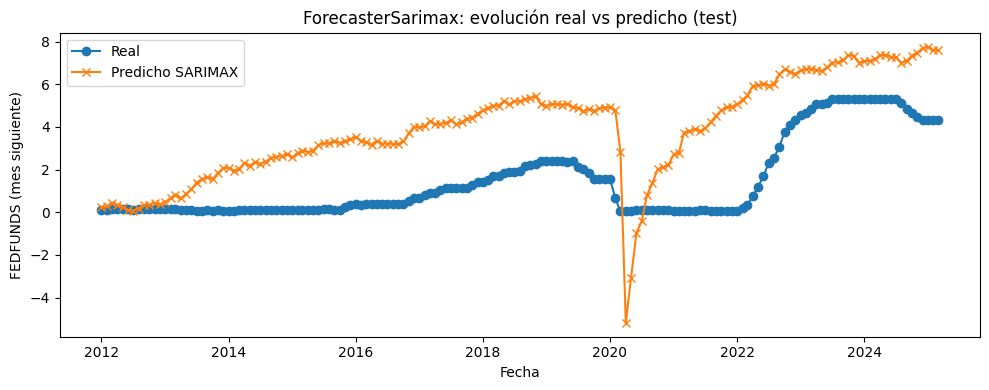


RESUMEN MSE EN TEST POR MODELO (sklearn + Sarimax):
LinearRegression         : MSE test = 1.2476
Ridge                    : MSE test = 1.2367
Lasso                    : MSE test = 1.1926
LinearRegression_sel_Lasso: MSE test = 1.2389
RandomForest             : MSE test = 0.2166
KNN                      : MSE test = 0.3527
GradientBoosting         : MSE test = 0.2018
Sarimax                  : MSE test = 7.8564



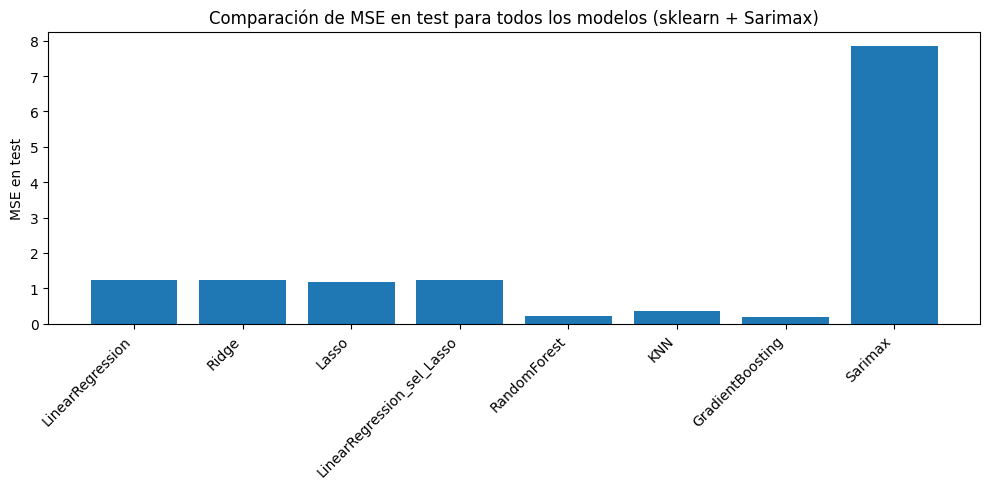

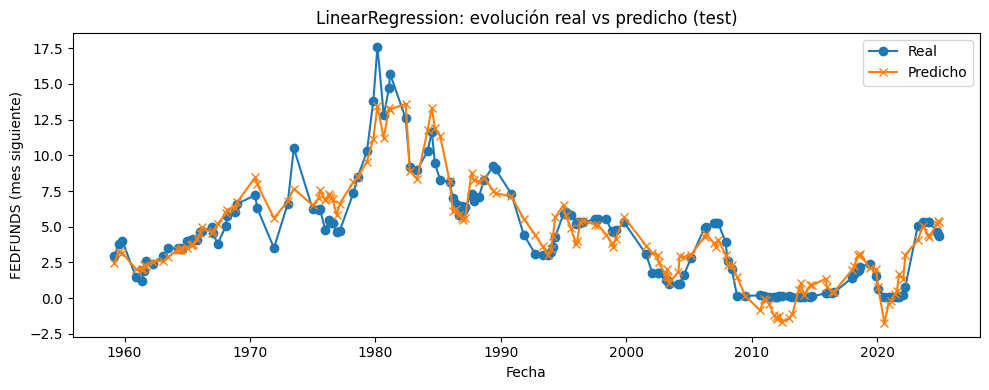

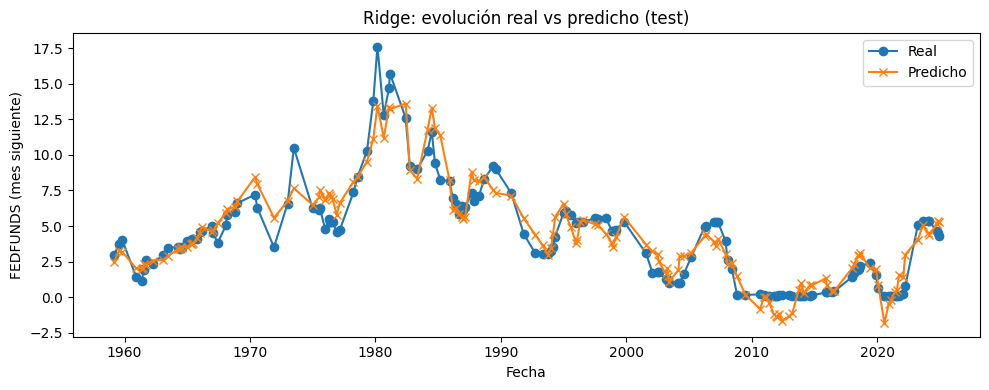

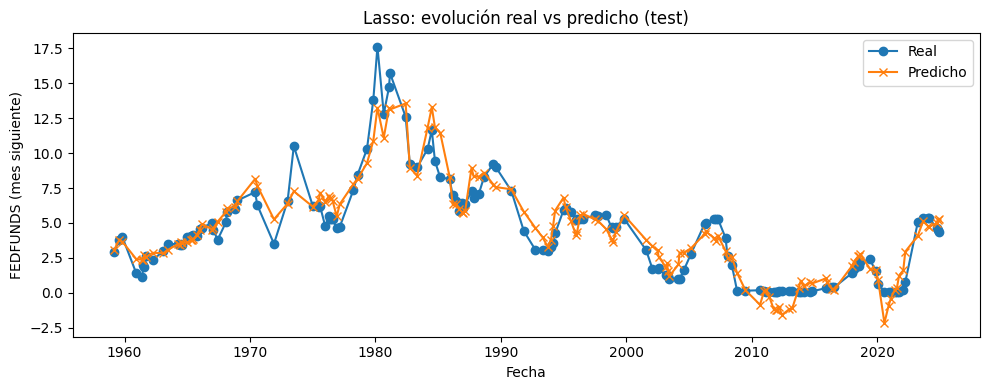

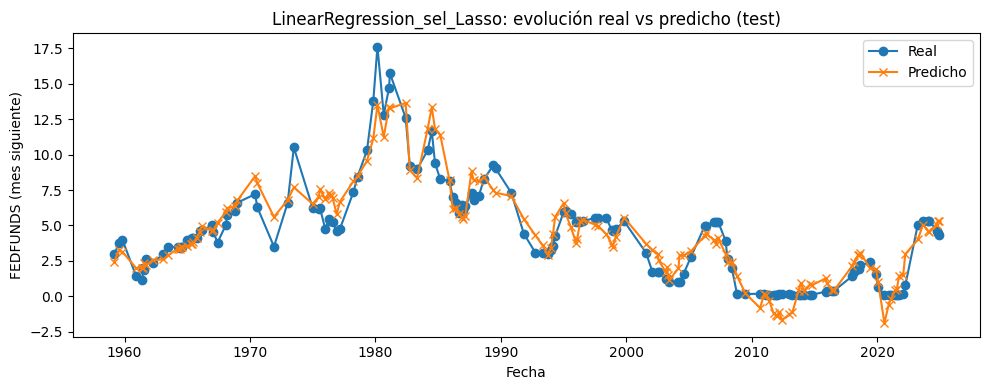

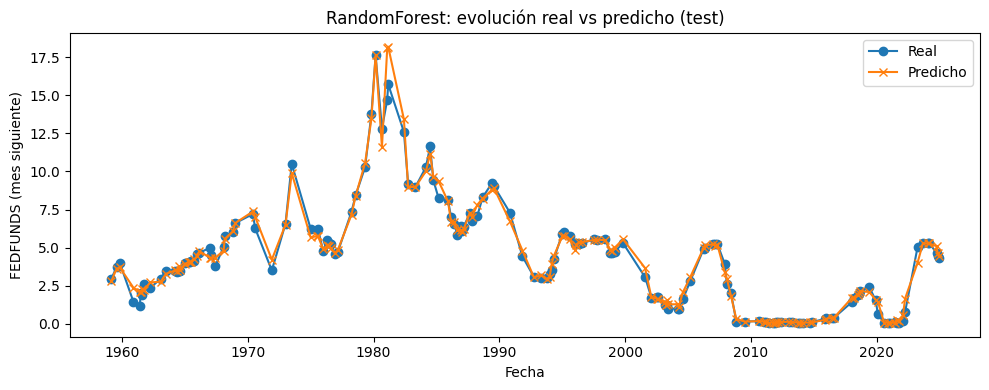

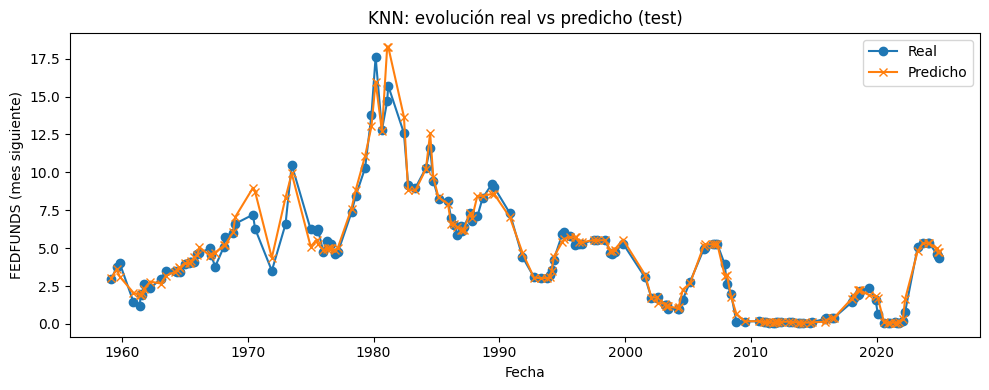

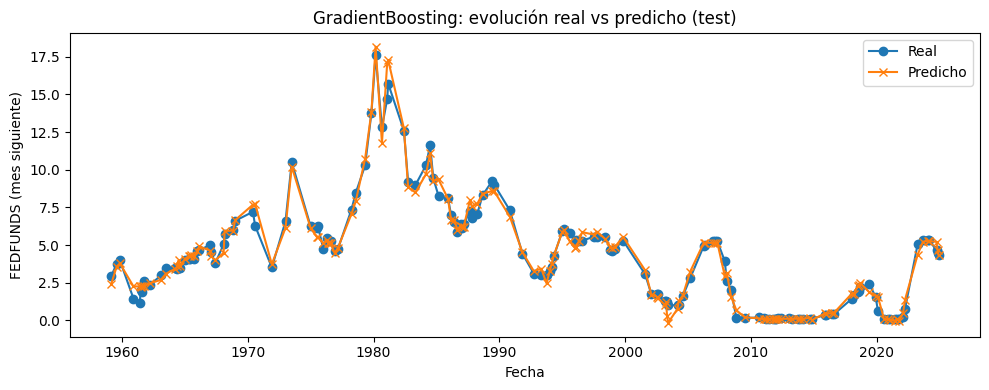

Mejor modelo LINEAL (sklearn) según MSE en test: Lasso
Mejor modelo NO LINEAL (sklearn) según MSE en test: GradientBoosting
Mejor modelo GLOBAL (sklearn + Sarimax) según MSE en test: GradientBoosting



In [4]:
# ---------------------------------------------------------------
# TRABAJO: Predicción del tipo de interés de la FED
#
# Modelos:
# - LinearRegression
# - Ridge (L2)
# - Lasso (L1) + selección de variables
# - LinearRegression con variables seleccionadas por Lasso
# - RandomForestRegressor (no lineal)
# - KNeighborsRegressor (no lineal)
# - GradientBoostingRegressor (no lineal avanzado)
# - ForecasterSarimax (modelo de series temporales con exógenas)
#
# Incluye:
# - Función de coste MSE
# - Validación cruzada (KFold)
# - Comparación de modelos (incluyendo Sarimax en MSE)
# - Gráficos individuales (real vs predicho) para sklearn
# - Gráfico real vs predicho para Sarimax
# - Predicción para mes/año elegido (mejor lineal y mejor no lineal sklearn)
# ---------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    GridSearchCV,
    cross_validate
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------------------------------------------------
# 1. CARGA Y PREPARACIÓN DEL DATASET
# -------------------------------------------------------------------

DATA_PATH = "US_DATA.xlsx"  # Cambia la ruta si hace falta
df = pd.read_excel(DATA_PATH)

df["observation_date"] = pd.to_datetime(df["observation_date"])
df = df.sort_values("observation_date").reset_index(drop=True)

# Variable objetivo: tipo FED del mes siguiente
df["FEDFUNDS_next"] = df["FEDFUNDS"].shift(-1)

# Eliminamos la última fila (no tiene valor siguiente)
df_model = df.dropna(subset=["FEDFUNDS_next"]).copy()

# Variables explicativas
feature_cols = ["GS10", "CPIAUCSL", "Unemployment rate", "POP", "NA000334Q", "PCE"]
target_col = "FEDFUNDS_next"

X = df_model[feature_cols].values
y = df_model[target_col].values
dates = df_model["observation_date"].values

print("Número total de observaciones:", len(df_model))
print("Features usadas:", feature_cols)
print()

# -------------------------------------------------------------------
# 2. FUNCIÓN DE COSTE Y UTILIDADES
# -------------------------------------------------------------------

def mse(y_true, y_pred):
    """Función de coste: error cuadrático medio (MSE)."""
    return mean_squared_error(y_true, y_pred)

def print_metrics(nombre_modelo, y_train, y_train_pred, y_test, y_test_pred):
    """Imprime MSE, MAE y R2 en train y test."""
    train_mse = mse(y_train, y_train_pred)
    test_mse = mse(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"==== {nombre_modelo} ====")
    print(f"MSE   train: {train_mse:.4f}   test: {test_mse:.4f}")
    print(f"MAE   train: {train_mae:.4f}   test: {test_mae:.4f}")
    print(f"R^2   train: {train_r2:.4f}   test: {test_r2:.4f}")
    print()

# -------------------------------------------------------------------
# 3. PARTICIÓN TRAIN / TEST (SKLEARN, SUPERVISADO)
# -------------------------------------------------------------------

X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, dates, test_size=0.2, random_state=42, shuffle=True
)

print("Tamaño train:", X_train.shape[0])
print("Tamaño test :", X_test.shape[0])
print()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Diccionarios para guardar modelos y resultados
models_fitted = {}      # modelos ya entrenados (sklearn)
model_test_preds = {}   # predicciones en test (sklearn)
model_test_mse = {}     # MSE en test (sklearn + Sarimax)

# -------------------------------------------------------------------
# 4. MODELO BASE: REGRESIÓN LINEAL
# -------------------------------------------------------------------

linreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

linreg_pipe.fit(X_train, y_train)
y_train_pred_lin = linreg_pipe.predict(X_train)
y_test_pred_lin = linreg_pipe.predict(X_test)

print_metrics("LinearRegression (sin regularización)",
              y_train, y_train_pred_lin, y_test, y_test_pred_lin)

models_fitted["LinearRegression"] = linreg_pipe
model_test_preds["LinearRegression"] = y_test_pred_lin
model_test_mse["LinearRegression"] = mse(y_test, y_test_pred_lin)

cv_mse_lin = -cross_val_score(
    linreg_pipe, X_train, y_train,
    scoring="neg_mean_squared_error",
    cv=kf
)
print("CV MSE LinearRegression (media ± std):",
      cv_mse_lin.mean(), "±", cv_mse_lin.std())
print()

# -------------------------------------------------------------------
# 5. RIDGE (L2) CON GRIDSEARCHCV
# -------------------------------------------------------------------

ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

ridge_param_grid = {
    "model__alpha": [0.01, 0.1, 1.0, 10.0, 100.0]
}

ridge_cv = GridSearchCV(
    ridge_pipe,
    param_grid=ridge_param_grid,
    scoring="neg_mean_squared_error",
    cv=kf,
    n_jobs=-1
)

ridge_cv.fit(X_train, y_train)

print("Mejor alpha Ridge:", ridge_cv.best_params_["model__alpha"])
print("Mejor CV MSE Ridge:", -ridge_cv.best_score_)
print()

best_ridge = ridge_cv.best_estimator_
y_train_pred_ridge = best_ridge.predict(X_train)
y_test_pred_ridge = best_ridge.predict(X_test)

print_metrics("Ridge (L2)",
              y_train, y_train_pred_ridge, y_test, y_test_pred_ridge)

models_fitted["Ridge"] = best_ridge
model_test_preds["Ridge"] = y_test_pred_ridge
model_test_mse["Ridge"] = mse(y_test, y_test_pred_ridge)

# -------------------------------------------------------------------
# 6. LASSO (L1) CON GRIDSEARCHCV + SELECCIÓN DE VARIABLES
# -------------------------------------------------------------------

lasso_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Lasso(max_iter=10000))
])

# Grid de alphas que puede llegar a eliminar PCE
lasso_param_grid = {
    "model__alpha": [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
}

lasso_cv = GridSearchCV(
    lasso_pipe,
    param_grid=lasso_param_grid,
    scoring="neg_mean_squared_error",
    cv=kf,
    n_jobs=-1
)

lasso_cv.fit(X_train, y_train)

print("Mejor alpha Lasso:", lasso_cv.best_params_["model__alpha"])
print("Mejor CV MSE Lasso:", -lasso_cv.best_score_)
print()

best_lasso = lasso_cv.best_estimator_
y_train_pred_lasso = best_lasso.predict(X_train)
y_test_pred_lasso = best_lasso.predict(X_test)

print_metrics("Lasso (L1)",
              y_train, y_train_pred_lasso, y_test, y_test_pred_lasso)

models_fitted["Lasso"] = best_lasso
model_test_preds["Lasso"] = y_test_pred_lasso
model_test_mse["Lasso"] = mse(y_test, y_test_pred_lasso)

# --- Variables seleccionadas por Lasso ---
lasso_coefs = best_lasso.named_steps["model"].coef_

print("Coeficientes Lasso por variable:")
for fname, coef in zip(feature_cols, lasso_coefs):
    print(f"{fname:20s}: {coef:.4f}")
print()

tol = 1e-4
selected_features = [
    fname for fname, coef in zip(feature_cols, lasso_coefs)
    if abs(coef) > tol
]

if len(selected_features) == 0:
    print("Lasso no ha llevado ninguna variable exactamente a 0 con este grid de alphas.")
    print("Puedes ajustar la lista de alphas si quieres forzar más sparsity.")
else:
    print("Variables seleccionadas por L1 (Lasso):", selected_features)
    print()

    # Creamos nuevos X_train_sel y X_test_sel solo con las variables seleccionadas
    selected_idx = [feature_cols.index(f) for f in selected_features]
    X_train_sel = X_train[:, selected_idx]
    X_test_sel = X_test[:, selected_idx]

    linreg_sel_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ])

    linreg_sel_pipe.fit(X_train_sel, y_train)
    y_train_pred_lin_sel = linreg_sel_pipe.predict(X_train_sel)
    y_test_pred_lin_sel = linreg_sel_pipe.predict(X_test_sel)

    print_metrics(
        "LinearRegression (solo variables seleccionadas por Lasso)",
        y_train, y_train_pred_lin_sel, y_test, y_test_pred_lin_sel
    )

    models_fitted["LinearRegression_sel_Lasso"] = linreg_sel_pipe
    model_test_preds["LinearRegression_sel_Lasso"] = y_test_pred_lin_sel
    model_test_mse["LinearRegression_sel_Lasso"] = mse(y_test, y_test_pred_lin_sel)

# -------------------------------------------------------------------
# 7. VALIDACIÓN CRUZADA DETALLADA PARA MODELOS LINEALES
# -------------------------------------------------------------------

models_dict_cv = {
    "LinearRegression": linreg_pipe,
    "Ridge": best_ridge,
    "Lasso": best_lasso
}

print("RESULTADOS CV (KFold=5) MODELOS LINEALES:")
for name, model in models_dict_cv.items():
    cv_res = cross_validate(
        model, X_train, y_train,
        scoring=("neg_mean_squared_error", "r2"),
        cv=kf,
        return_train_score=True
    )
    print(f"\n=== {name} ===")
    print("MSE train (media):", -cv_res["train_neg_mean_squared_error"].mean())
    print("MSE val   (media):", -cv_res["test_neg_mean_squared_error"].mean())
    print("R2  train (media):", cv_res["train_r2"].mean())
    print("R2  val   (media):", cv_res["test_r2"].mean())
print()

# -------------------------------------------------------------------
# 8. MODELOS NO LINEALES: RANDOM FOREST, KNN, GRADIENT BOOSTING
# -------------------------------------------------------------------

# 8.a Random Forest (no necesita escalado)
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42
)

rf_model.fit(X_train, y_train)
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

print_metrics("RandomForestRegressor",
              y_train, y_train_pred_rf, y_test, y_test_pred_rf)

models_fitted["RandomForest"] = rf_model
model_test_preds["RandomForest"] = y_test_pred_rf
model_test_mse["RandomForest"] = mse(y_test, y_test_pred_rf)

# 8.b KNN (necesita escalado)
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsRegressor())
])

knn_pipe.fit(X_train, y_train)
y_train_pred_knn = knn_pipe.predict(X_train)
y_test_pred_knn = knn_pipe.predict(X_test)

print_metrics("KNeighborsRegressor",
              y_train, y_train_pred_knn, y_test, y_test_pred_knn)

models_fitted["KNN"] = knn_pipe
model_test_preds["KNN"] = y_test_pred_knn
model_test_mse["KNN"] = mse(y_test, y_test_pred_knn)

# 8.c Gradient Boosting (no lineal avanzado)
gb_model = GradientBoostingRegressor(random_state=42)

gb_param_grid = {
    "n_estimators":  [100, 300],
    "learning_rate": [0.05, 0.1],
    "max_depth":     [2, 3]
}

gb_cv = GridSearchCV(
    estimator=gb_model,
    param_grid=gb_param_grid,
    scoring="neg_mean_squared_error",
    cv=kf,
    n_jobs=-1
)

gb_cv.fit(X_train, y_train)

print("\nMejores hiperparámetros GradientBoosting:", gb_cv.best_params_)
print("Mejor CV MSE GradientBoosting:", -gb_cv.best_score_)

best_gb = gb_cv.best_estimator_

y_train_pred_gb = best_gb.predict(X_train)
y_test_pred_gb  = best_gb.predict(X_test)

print_metrics("GradientBoostingRegressor",
              y_train, y_train_pred_gb, y_test, y_test_pred_gb)

models_fitted["GradientBoosting"]    = best_gb
model_test_preds["GradientBoosting"] = y_test_pred_gb
model_test_mse["GradientBoosting"]   = mse(y_test, y_test_pred_gb)

# -------------------------------------------------------------------
# 9. MODELO DE SERIES TEMPORALES: FORECASTERSARIMAX (skforecast)
# -------------------------------------------------------------------

try:
    import skforecast
    from skforecast.sarimax import Sarimax
    from skforecast.recursive import ForecasterSarimax
    print(f"\nskforecast version: {skforecast.__version__}")
except Exception as e:
    print("\nNo se ha podido importar skforecast para Sarimax.")
    print("Instala skforecast y statsmodels si quieres usar ForecasterSarimax.")
    print("Error:", e)
    ForecasterSarimax = None

if 'ForecasterSarimax' in globals() and ForecasterSarimax is not None:
    # Creamos serie temporal con índice de fechas
    df_ts = df_model.copy().set_index("observation_date").sort_index()

    # Inferimos frecuencia
    inferred_freq = pd.infer_freq(df_ts.index)
    print("Frecuencia inferida del índice (Sarimax):", inferred_freq)

    if inferred_freq is None:
        # asumimos mensual si no se puede inferir
        inferred_freq = "M"

    df_ts = df_ts.asfreq(inferred_freq)

    y_ts = df_ts[target_col]
    exog_ts = df_ts[feature_cols]

    # Split temporal 80% / 20%
    split_idx_ts = int(len(df_ts) * 0.8)
    y_train_ts = y_ts.iloc[:split_idx_ts]
    y_test_ts = y_ts.iloc[split_idx_ts:]
    exog_train_ts = exog_ts.iloc[:split_idx_ts]
    exog_test_ts = exog_ts.iloc[split_idx_ts:]

    print("\nTamaño serie Sarimax train:", len(y_train_ts))
    print("Tamaño serie Sarimax test :", len(y_test_ts))
    print("Frecuencia del índice tras asfreq:", y_ts.index.freq)

    # Definimos el forecaster SARIMAX
    forecaster_sarimax = ForecasterSarimax(
        regressor=Sarimax(order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
    )

    # Entrenamos con exógenas
    forecaster_sarimax.fit(
        y=y_train_ts,
        exog=exog_train_ts,
        suppress_warnings=True
    )

    # Predicción sobre el bloque test
    y_pred_sarimax = forecaster_sarimax.predict(
        steps=len(y_test_ts),
        exog=exog_test_ts
    )

    sarimax_mse = mse(y_test_ts.values, y_pred_sarimax.values)
    sarimax_mae = mean_absolute_error(y_test_ts.values, y_pred_sarimax.values)
    sarimax_r2 = r2_score(y_test_ts.values, y_pred_sarimax.values)

    print("\n==== ForecasterSarimax (skforecast) ====")
    print(f"MSE  test: {sarimax_mse:.4f}")
    print(f"MAE  test: {sarimax_mae:.4f}")
    print(f"R^2  test: {sarimax_r2:.4f}")

    # Lo añadimos a la tabla y gráfico de MSE
    model_test_mse["Sarimax"] = sarimax_mse

    # Gráfico real vs predicho para Sarimax
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_ts.index, y_test_ts.values, label="Real", marker="o")
    plt.plot(y_test_ts.index, y_pred_sarimax.values, label="Predicho SARIMAX", marker="x")
    plt.xlabel("Fecha")
    plt.ylabel("FEDFUNDS (mes siguiente)")
    plt.title("ForecasterSarimax: evolución real vs predicho (test)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------------
# 10. COMPARACIÓN FINAL Y ELECCIÓN DE MODELOS
# -------------------------------------------------------------------

print("\nRESUMEN MSE EN TEST POR MODELO (sklearn + Sarimax):")
for name, mse_val in model_test_mse.items():
    print(f"{name:25s}: MSE test = {mse_val:.4f}")
print()

# Gráfico resumen (barras) por modelo (incluye Sarimax)
model_names = list(model_test_mse.keys())
mse_values = [model_test_mse[n] for n in model_names]

plt.figure(figsize=(10, 5))
plt.bar(model_names, mse_values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("MSE en test")
plt.title("Comparación de MSE en test para todos los modelos (sklearn + Sarimax)")
plt.tight_layout()
plt.show()

# Gráficos individuales: evolución real vs predicho (test) SOLO para modelos sklearn
order = np.argsort(dates_test)
dates_test_sorted = dates_test[order]
y_test_sorted = y_test[order]

for name, y_pred in model_test_preds.items():
    y_pred_sorted = y_pred[order]

    plt.figure(figsize=(10, 4))
    plt.plot(dates_test_sorted, y_test_sorted, label="Real", marker="o")
    plt.plot(dates_test_sorted, y_pred_sorted, label="Predicho", marker="x")
    plt.xlabel("Fecha")
    plt.ylabel("FEDFUNDS (mes siguiente)")
    plt.title(f"{name}: evolución real vs predicho (test)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Elección de:
# - mejor modelo lineal (sklearn)
# - mejor modelo no lineal (sklearn)

linear_candidates_all = ["LinearRegression", "Ridge", "Lasso", "LinearRegression_sel_Lasso"]
linear_candidates = [n for n in linear_candidates_all if n in model_test_mse]

nonlinear_candidates = ["RandomForest", "KNN", "GradientBoosting"]

best_linear_name = min(linear_candidates, key=lambda n: model_test_mse[n])
best_nonlinear_name = min(nonlinear_candidates, key=lambda n: model_test_mse[n])

print("Mejor modelo LINEAL (sklearn) según MSE en test:", best_linear_name)
print("Mejor modelo NO LINEAL (sklearn) según MSE en test:", best_nonlinear_name)

best_overall_name = min(model_test_mse.keys(), key=lambda n: model_test_mse[n])
print("Mejor modelo GLOBAL (sklearn + Sarimax) según MSE en test:", best_overall_name)
print()

# -------------------------------------------------------------------
# 11. PREDICCIÓN INTERACTIVA (MODELO LINEAL Y NO LINEAL SKLEARN)
# -------------------------------------------------------------------

def pedir_fecha_y_predecir():
    print("Introduce año y mes para predecir FEDFUNDS_next con los modelos sklearn.")
    anio = int(input("Año (por ejemplo 2008): "))
    mes = int(input("Mes (1-12): "))

    # Buscamos la fila de ese mes/año en el dataframe model
    mask = (df_model["observation_date"].dt.year == anio) & (df_model["observation_date"].dt.month == mes)
    if not mask.any():
        print("No hay datos para ese mes/año en el dataset.")
        return

    fila = df_model.loc[mask].iloc[-1]  # por si hubiera más de una, cogemos la última
    x_values = fila[feature_cols].values.reshape(1, -1)

    # Predicciones con el mejor modelo lineal y no lineal
    best_linear_model = models_fitted[best_linear_name]
    best_nonlinear_model = models_fitted[best_nonlinear_name]

    y_pred_linear = best_linear_model.predict(x_values)[0]
    y_pred_nonlinear = best_nonlinear_model.predict(x_values)[0]

    print(f"\nPredicciones para {anio}-{mes:02d}:")
    print(f"  Modelo lineal ({best_linear_name}):       {y_pred_linear:.4f}")
    print(f"  Modelo no lineal ({best_nonlinear_name}): {y_pred_nonlinear:.4f}")
    print()